In [53]:
#importing necessary packages

from tensorflow.keras.utils import array_to_img, img_to_array, load_img



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import Adam
from keras.utils import array_to_img, img_to_array, load_img
from keras.regularizers import l1 , l2 
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This prevents kernel shut down due to xgboost conflict
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # This line prevents tf's comments about the optimizing your machine

# Directory path
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



# Get all the data in the directory chest_xray/train (5216 images) and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (200, 200),
        batch_size=5216, class_mode='binary')

# Get all the data in the directory chest_xray/test (624 images) , and reshape them
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (200, 200),
        batch_size=624, class_mode='binary')


# Get all the data in the directory chest_xray/val (16 images), and reshape them
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = (200, 200),
        batch_size=16, class_mode='binary')


In [2]:
# Directory path
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



# Get all the data in the directory chest_xray/train (5216 images) and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=5216, class_mode='binary')

# Get all the data in the directory chest_xray/test (624 images) , and reshape them
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=624, class_mode='binary')


# Get all the data in the directory chest_xray/val (16 images), and reshape them
val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=16, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [3]:
# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [4]:
# Previewing shape of each dataset

print("Image Dataset Shape")
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

print("Label Dataset Shape")
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)



Image Dataset Shape
(5216, 256, 256, 3)
(624, 256, 256, 3)
(16, 256, 256, 3)
Label Dataset Shape
(5216,)
(624,)
(16,)


In [5]:
example_img = train_images[10]

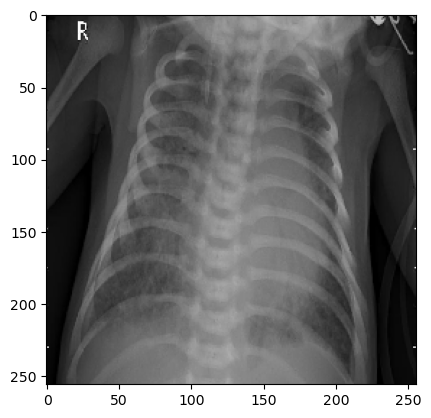

In [6]:
plt.imshow(example_img)

In [7]:
# Reshaping image datasets
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 196608)
(624, 196608)
(16, 196608)


In [8]:
train_img[:10]

array([[0.14117648, 0.14117648, 0.14117648, ..., 0.20784315, 0.20784315,
        0.20784315],
       [0.65882355, 0.65882355, 0.65882355, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.07450981, 0.07450981, 0.07450981, ..., 0.1254902 , 0.1254902 ,
        0.1254902 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [9]:
# Reshaping labels
train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(5216, 1)
(624, 1)
(16, 1)


In [10]:
# Viewing first 10 labels
train_y[:10]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [11]:
# Viewing class indices
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Baseline Model 

In [12]:
# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                2359308   
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Fitting the model to the training data
results_1 = model_1.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Epoch 1/10
163/163 [==============================] - 25s 140ms/step - loss: 1.5167 - accuracy: 0.7138 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 27s 164ms/step - loss: 0.6329 - accuracy: 0.7429 - val_loss: 0.7121 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 23s 141ms/step - loss: 0.6059 - accuracy: 0.7429 - val_loss: 0.7316 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 21s 127ms/step - loss: 0.5889 - accuracy: 0.7429 - val_loss: 0.7535 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 20s 125ms/step - loss: 0.5791 - accuracy: 0.7429 - val_loss: 0.7744 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 19s 118ms/step - loss: 0.5739 - accuracy: 0.7429 - val_loss: 0.7917 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 20s 124ms/step - loss: 0.5717 - accuracy: 0.7429 - val_loss: 0.8048 - val_ac

In [14]:
# Training Results 
results_train = model_1.evaluate(train_img, train_y)

# Test Results 

results_test = model_1.evaluate(test_img, test_y)

20/20 [==============================] - 3s 108ms/step - loss: 0.6930 - accuracy: 0.6250


In [15]:
print('Train Results:', results_train)
print('Test Results:', results_test)

Train Results: [0.5700258016586304, 0.7429064512252808]
Test Results: [0.6930213570594788, 0.625]


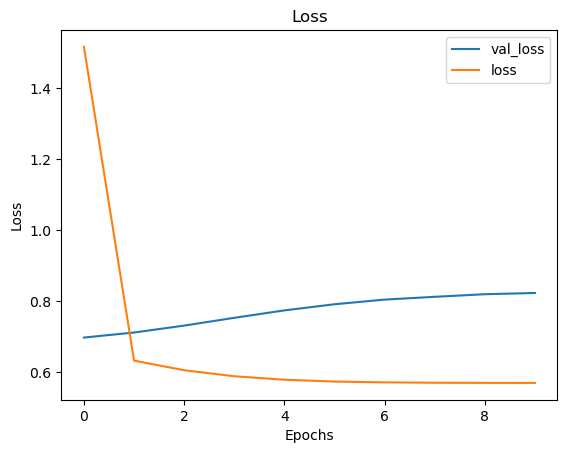

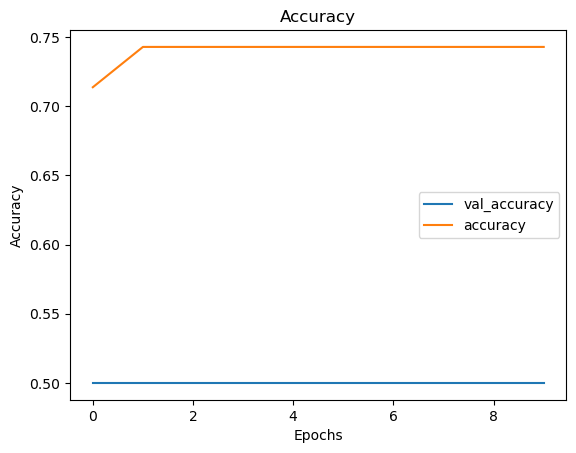

In [16]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_1)

## Model 2

In [17]:
# Model 2 changing activation function in first 2 layers

model_2 = Sequential()
model_2.add(Dense(12, activation='tanh', input_shape=(196608,)))
model_2.add(Dense(8, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_2.summary()

# Fitting the model to the training data
results_2 = model_2.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                2359308   
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 22s 123ms/step - loss: 0.5749 - accuracy: 0.7414 - val_loss: 0.8099 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 19s 114ms/step - loss: 0.5707 - accuracy: 0.7429 - val_loss: 0.8365 - val_accuracy: 0.5000
Epoch 3/10
163/163

In [18]:
# Training Results 
results2_train = model_2.evaluate(train_img, train_y)

# Test Results 

results2_test = model_2.evaluate(test_img, test_y)

20/20 [==============================] - 2s 64ms/step - loss: 0.6953 - accuracy: 0.6250


In [19]:
print('Train Results:', results2_train)
print('Test Results:', results2_test)

Train Results: [0.5699954032897949, 0.7429064512252808]
Test Results: [0.6953195333480835, 0.625]


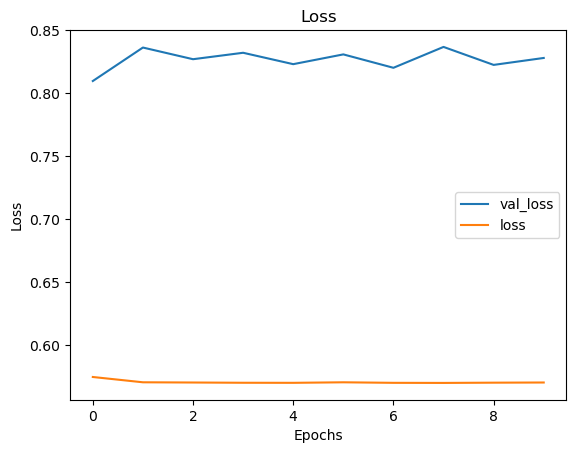

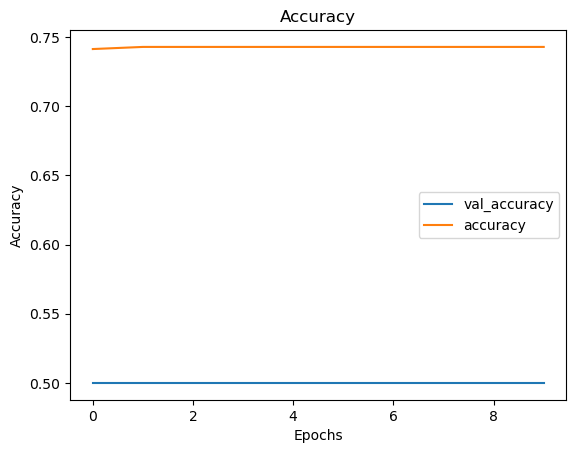

In [20]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_2)

## Model 3

In [21]:
# Model 3 
# Adding more neurons per layer and one extra layer 

model_3 = Sequential()
model_3.add(Dense(64, activation='tanh', input_shape=(196608,)))
model_3.add(Dense(32, activation='tanh'))
model_3.add(Dense(16, activation='tanh'))
model_3.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_3.summary()

# Fitting the model to the training data
results_3 = model_3.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                12582976  
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 32s 187ms/step - loss: 0.5761 - accuracy: 0.7391 - val_loss: 0.8030 - val_accuracy: 0.5000
Epoch 2/10
163/163 [=========

In [22]:
# Training Results 
results3_train = model_3.evaluate(train_img, train_y)

# Test Results 

results3_test = model_3.evaluate(test_img, test_y)

20/20 [==============================] - 3s 103ms/step - loss: 0.6952 - accuracy: 0.6250


In [23]:
print('Train Results:', results3_train)
print('Test Results:', results3_test)

Train Results: [0.569995105266571, 0.7429064512252808]
Test Results: [0.695216178894043, 0.625]


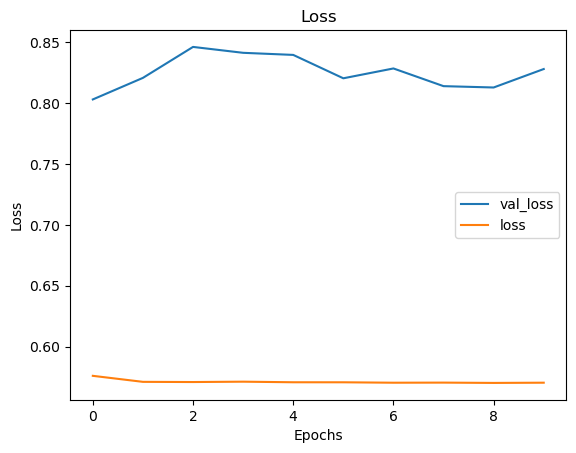

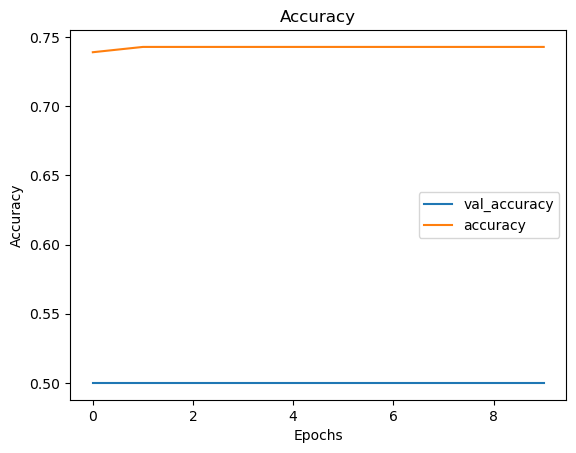

In [24]:
# Viewing results 
visualize_training_results(results_3)

## Model 4

In [25]:
# Model 4
# adjusting activation function from previous model 3

model_4 = Sequential()
model_4.add(Dense(64, activation='relu', input_shape=(196608,)))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_4.summary()

# Fitting the model to the training data
results_4 = model_4.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                12582976  
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 44s 257ms/step - loss: 0.8471 - accuracy: 0.8286 - val_loss: 0.2849 - val_accuracy: 0.8750
Epoch 2/10
163/163 [=========

In [26]:
# Training Results 
results4_train = model_4.evaluate(train_img, train_y)

# Test Results 
results4_test = model_4.evaluate(test_img, test_y)

print('Train Results:', results4_train)
print('Test Results:', results4_test)


20/20 [==============================] - 2s 75ms/step - loss: 0.9515 - accuracy: 0.7660
Train Results: [0.08690128475427628, 0.9695168733596802]
Test Results: [0.9514895677566528, 0.7660256624221802]


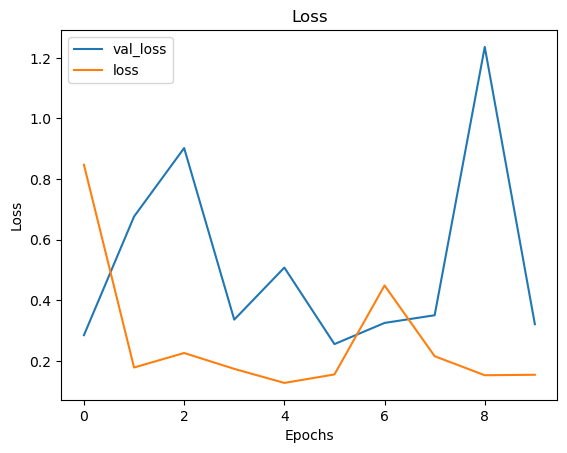

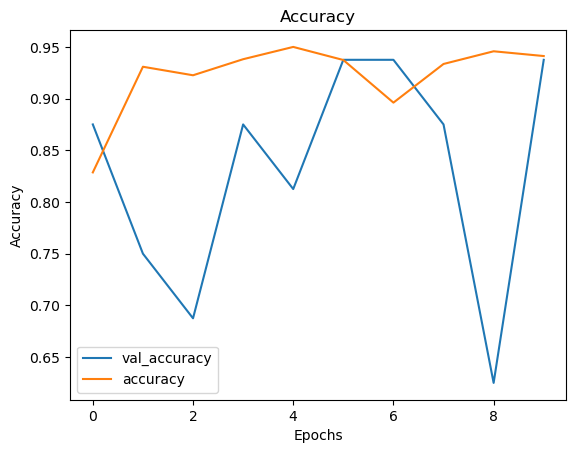

In [27]:
# Viewing results 
visualize_training_results(results_4)

## Model 5

In [28]:
# Model 5 increased epochs from 10 to 20 


model_5 = Sequential()
model_5.add(Dense(64, activation='relu', input_shape=(196608,)))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(16, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_5.summary()

# Fitting the model to the training data
results_5 = model_5.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                12582976  
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 32s 187ms/step - loss: 1.0587 - accuracy: 0.8273 - val_loss: 0.9226 - val_accuracy: 0.6875
Epoch 2/20
163/163 [=========

In [29]:
# Training Results 
results5_train = model_5.evaluate(train_img, train_y)

# Test Results 
results5_test = model_5.evaluate(test_img, test_y)

print('Train Results:', results5_train)
print('Test Results:', results5_test)


20/20 [==============================] - 2s 73ms/step - loss: 0.5025 - accuracy: 0.8141
Train Results: [0.1903623342514038, 0.9321318864822388]
Test Results: [0.5024653673171997, 0.8141025900840759]


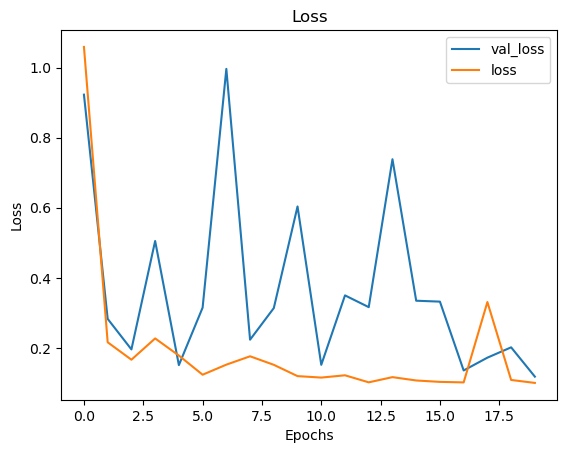

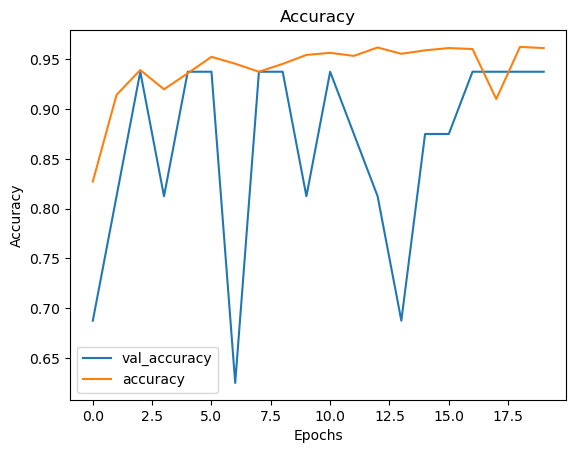

In [30]:
# Viewing results 
visualize_training_results(results_5)

With the increase to 20 epochs the training accuracy increased while test accuracy also increased greatly from the previous model. Looking at the top visual, we can see that loss seems to be improving as Epochs are increase. 

I plan to increase the Epochs to 50 to see how this influences the metrics. 

## Model 6

In [31]:
# Model 6 increased epochs from 20 to 30


model_6 = Sequential()
model_6.add(Dense(64, activation='relu', input_shape=(196608,)))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(16, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_6.summary()

# Fitting the model to the training data
results_6 = model_6.fit(train_img, train_y, 
                        epochs=30, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                12582976  
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
163/163 [==============================] - 44s 254ms/step - loss: 1.7641 - accuracy: 0.8232 - val_loss: 2.6814 - val_accuracy: 0.6250
Epoch 2/30
163/163 [=========

In [32]:
# Training Results 
results6_train = model_6.evaluate(train_img, train_y)

# Test Results 
results6_test = model_6.evaluate(test_img, test_y)

print('Train Results:', results6_train)
print('Test Results:', results6_test)


20/20 [==============================] - 3s 108ms/step - loss: 0.5682 - accuracy: 0.8125
Train Results: [0.09268513321876526, 0.9647239446640015]
Test Results: [0.5682278275489807, 0.8125]


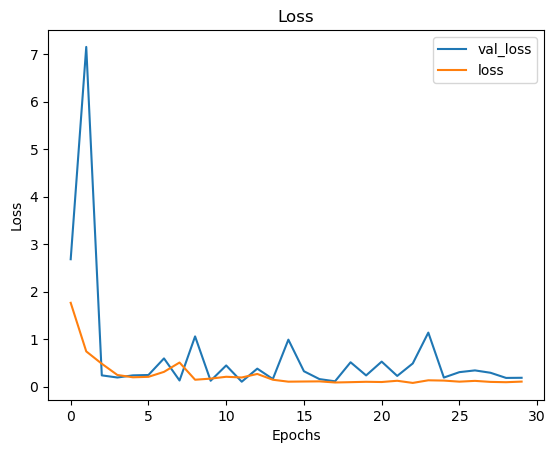

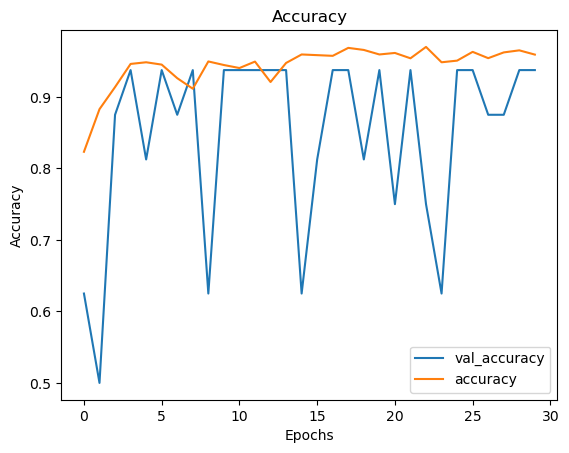

In [33]:
# Viewing results 
visualize_training_results(results_6)

With increasing Epochs from 20 to 30, there was slight improvement training accuracy going from ~93% to ~96%, however test accuracy remained virtually the same at ~81%. Since the model seemed to increase in overfitting with 30 Epochs. Planning to try one additional adjustment regarding Epochs with testing model by reducing to 15 Epochs. 

## Model 7

In [34]:
# Model 7 Epochs will be adjusted to 15


model_7 = Sequential()
model_7.add(Dense(64, activation='relu', input_shape=(196608,)))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(16, activation='relu'))
model_7.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_7.summary()

# Fitting the model to the training data
results_7 = model_7.fit(train_img, train_y, 
                        epochs=15, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                12582976  
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
163/163 [==============================] - 45s 265ms/step - loss: 2.3676 - accuracy: 0.8459 - val_loss: 1.0944 - val_accuracy: 0.6875
Epoch 2/15
163/163 [=========

In [35]:
# Training Results 
results7_train = model_7.evaluate(train_img, train_y)

# Test Results 
results7_test = model_7.evaluate(test_img, test_y)

print('Train Results:', results7_train)
print('Test Results:', results7_test)

20/20 [==============================] - 3s 109ms/step - loss: 0.5536 - accuracy: 0.8045
Train Results: [0.22628697752952576, 0.9112346768379211]
Test Results: [0.5536491870880127, 0.8044871687889099]


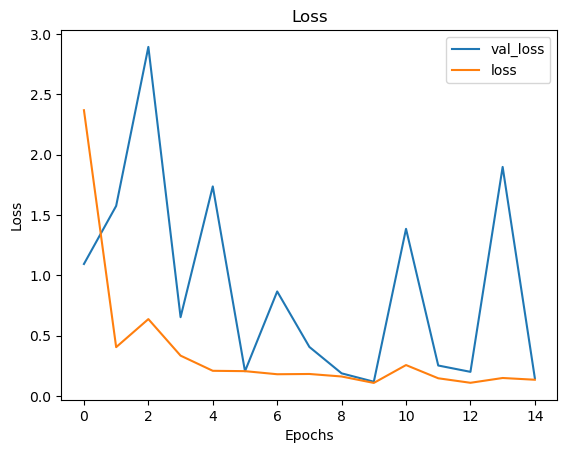

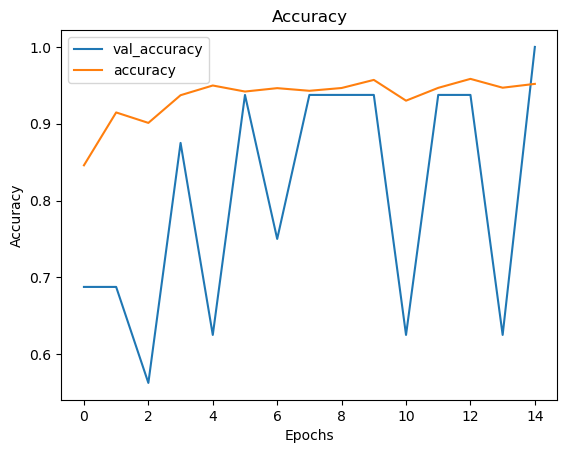

In [37]:
# Viewing results 
visualize_training_results(results_7)

## Model 8

In [54]:
# Model 8 Epochs of 20 
# L1 regularization added

model_8 = Sequential()
model_8.add(Dense(64, activation='relu', input_shape=(196608,)))
model_8.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
model_8.add(Dense(16, activation='relu'))
model_8.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_8.summary()

# Fitting the model to the training data
results_8 = model_8.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                12582976  
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 74s 435ms/step - loss: 2.6271 - accuracy: 0.8455 - val_loss: 1.2184 - val_accuracy: 0.8750
Epoch 2/20
163/163 [========

In [55]:
# Training Results 
results8_train = model_8.evaluate(train_img, train_y)

# Test Results 
results8_test = model_8.evaluate(test_img, test_y)

print('Train Results:', results8_train)
print('Test Results:', results8_test)

20/20 [==============================] - 4s 176ms/step - loss: 1.3803 - accuracy: 0.7212
Train Results: [0.25414934754371643, 0.9675996899604797]
Test Results: [1.3803304433822632, 0.7211538553237915]


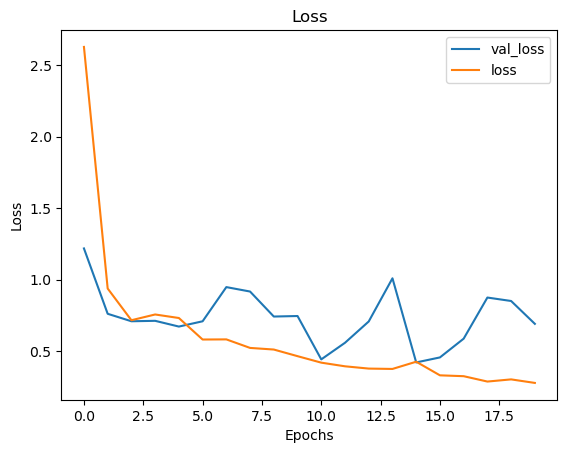

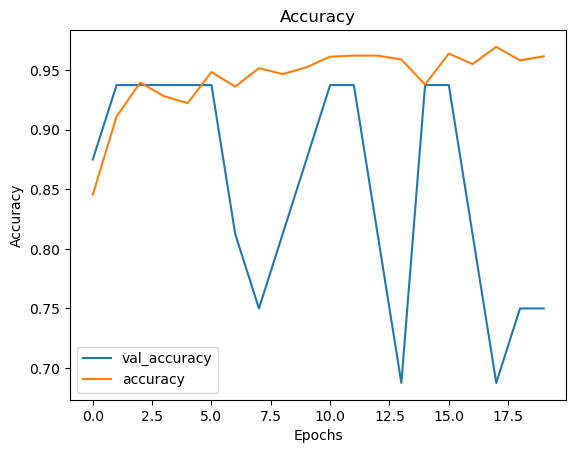

In [56]:
# Viewing results 
visualize_training_results(results_8)

## Model 9

In [49]:
# Model 9 Epochs of 20, added one extra layer
# added l1 regularization


model_9 = Sequential()
model_9.add(Dense(64, activation='relu', input_shape=(196608,)))
model_8.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
model_9.add(Dense(16, activation='relu'))
model_9.add(Dense(8, activation='relu'))
model_9.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_9.summary()

# Fitting the model to the training data
results_9 = model_9.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 64)                12582976  
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                                 
 dense_44 (Dense)            (None, 16)                528       
                                                                 
 dense_45 (Dense)            (None, 8)                 136       
                                                                 
 dense_46 (Dense)            (None, 1)                 9         
                                                                 
Total params: 12,585,729
Trainable params: 12,585,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
163/163 [======================

In [50]:
# Training Results 
results9_train = model_9.evaluate(train_img, train_y)

# Test Results 
results9_test = model_9.evaluate(test_img, test_y)

print('Train Results:', results9_train)
print('Test Results:', results9_test)

20/20 [==============================] - 4s 186ms/step - loss: 0.8457 - accuracy: 0.7468
Train Results: [0.08743816614151001, 0.9675996899604797]
Test Results: [0.8456550240516663, 0.7467948794364929]


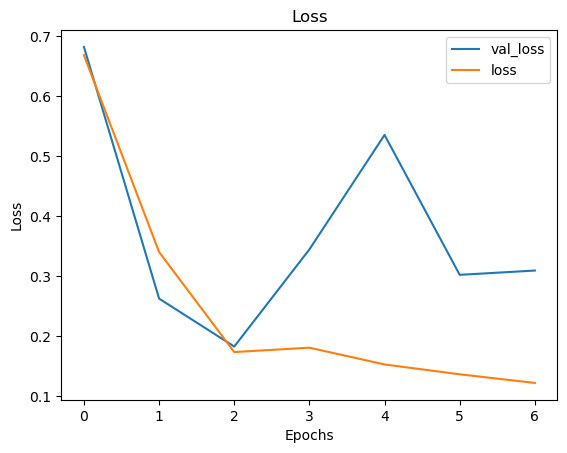

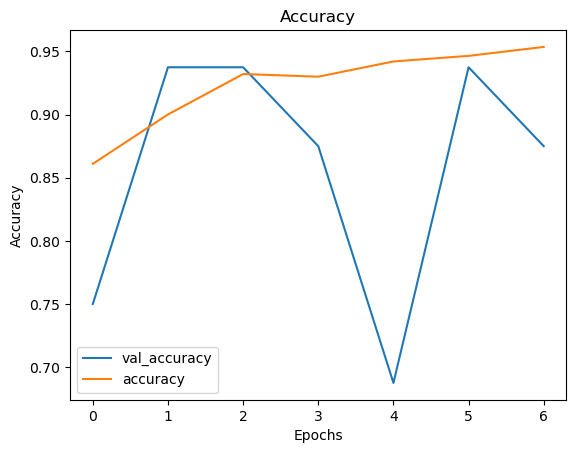

In [51]:
# Viewing results 
visualize_training_results(results_9)

# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()

# Fitting the model to the training data
results_2 = model_2.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results3_train = model_3.evaluate(train_img, train_y)

# Test Results 

results3_test = model_3.evaluate(test_img, test_y)

print('Train Results:', results3_train)
print('Test Results:', results3_test)

# Viewing results 
visualize_training_results(results_3)